In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
plt.style.use('dark_background')
# plt.style.use('default')
plt.rc('figure', figsize=(6,4))
plt.rc('font', size=11)
%config InlineBackend.figure_format='retina'

In [2]:
import quflow as qf

# Generate random vorticity and plot it

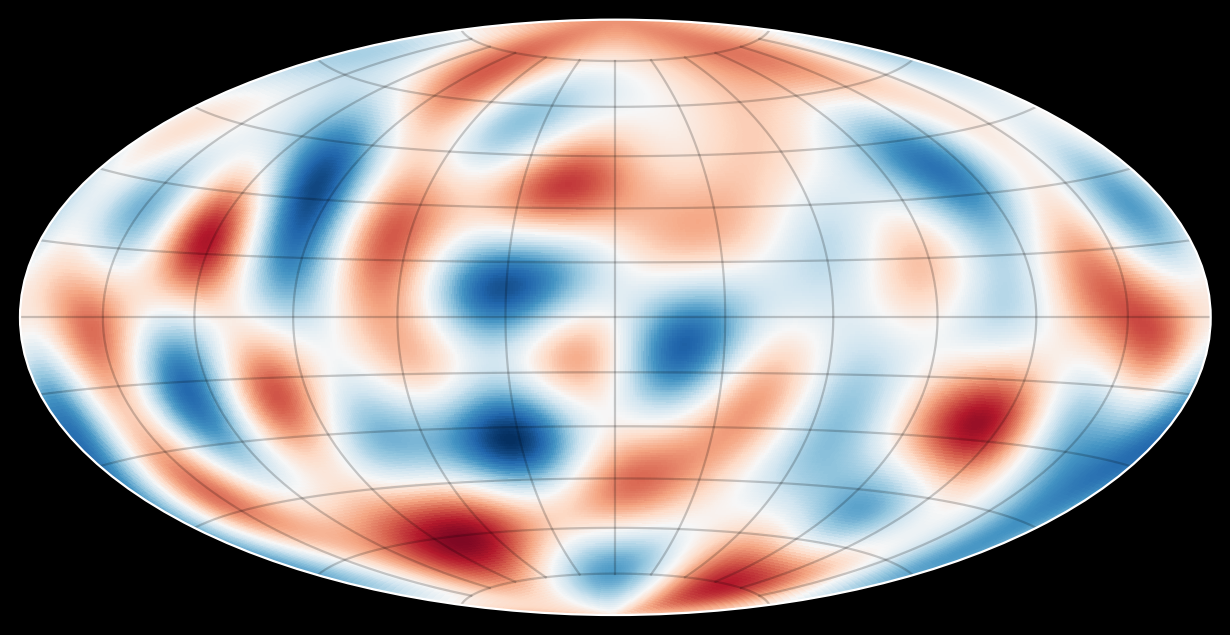

In [3]:
lmax = 10  # How many spherical harmonics (SH) coefficients to include
np.random.seed(42)  # For reproducability
omega0 = np.random.randn(lmax**2)  # Array with SH coefficients
omega0[0] = 0.0  # Set vanishing total circulation
omega0[1:4] = 0.0  # Set vanishing total angular momentum
qf.plot2(omega0, projection="hammer", N=256)  # Plot command

# Simulation of Euler's equations on the sphere

In vorticity formulation, Euler's equations are
$$\dot\omega = \{\psi,\omega\} $$
where $\omega$ is the vorticity function and $\psi$ is the stream function (related to $\omega$ via Poisson's equation). The quantized Euler equations are similar
$$\dot W = [P,W] $$
but here the vorticity function is replaced by the vorticity matrix $W \in \mathfrak{su}(N)$ and a corresponding stream matrix $P\in\mathfrak{su}(N)$.


## Create initial conditions

In [4]:
N = 128  # Size of matrices
W0 = qf.shr2mat(omega0, N=N)  # Convert SH coefficients to matrix
P0 = qf.solve_poisson(W0)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Run simulation

In [5]:
filename = "my_sim_N_{}.hdf5".format(str(N))
time = 2.0 # in second
inner_time = 0.1 # in seconds
qstepsize = 0.05 # in qtime

In [6]:
# Run this if you want to remove the existing hdf5 file
%rm $filename

In [7]:
dt = qf.qtime2seconds(qstepsize, N)
print("The physical stepsize is {:.3e} seconds, which yields".format(dt))
print("in total {} steps, with {} steps per output, and thus {} output steps.".format(round(time/dt), round(inner_time/dt), round(time/inner_time)))

The physical stepsize is 2.448e-04 seconds, which yields
in total 8170 steps, with 409 steps per output, and thus 20 output steps.


In [8]:
# Callback data object
mysim = qf.QuData(filename)

# Save initial conditions if file does not exist already, otherwise load from last step
try:
    f = h5py.File(filename, "r")
except IOError or KeyError:
    W = W0.copy()
    mysim(W, 0.0)
else:
    W = qf.shr2mat(f['state'][-1,:], N=N)
    assert W.shape[0] == N, "Looks like the saved data use N = {} whereas you specified N = {}.".format(W.shape[0], N)
    f.close()

# Select solver
solver = qf.isomp  # this is actually the default choice, so not really needed

# Run simulation
qf.solve(W, stepsize=qstepsize, time=time, inner_time=inner_time, callback=mysim,
         method=solver, method_kwargs={"verbatim":False, "maxit":10})

# Flush cache data
mysim.flush()

  0%|          | 0/8170 [00:00<?, ? steps/s]

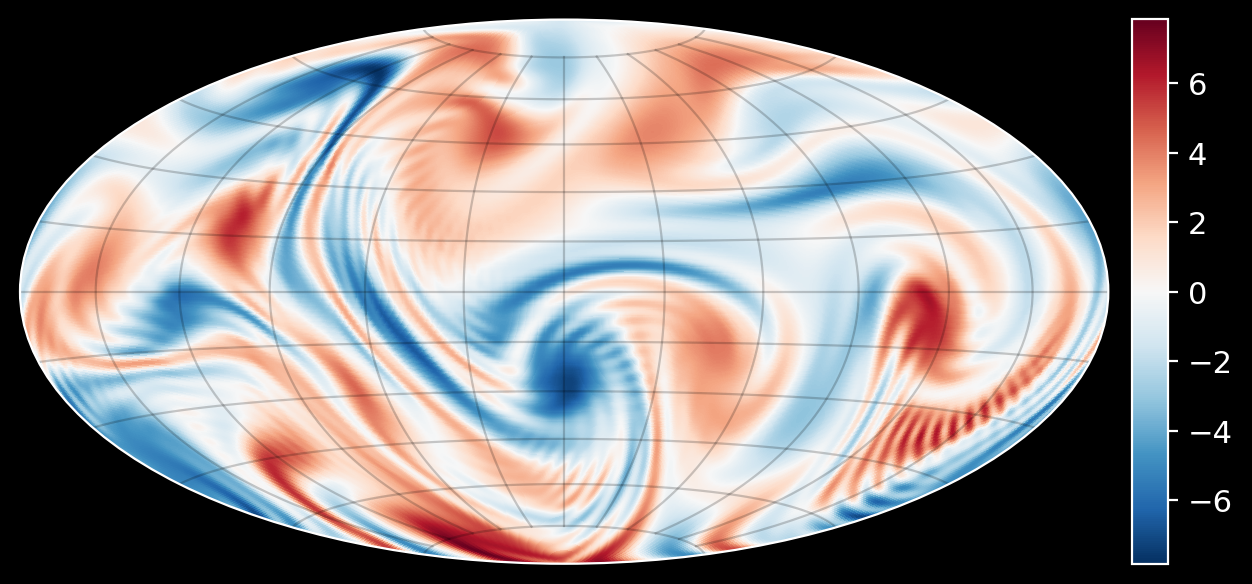

In [9]:
# Plot last state
with h5py.File(filename, 'r') as data:
    omega = data['state'][-1]
    qf.plot2(omega, projection='hammer', N=512, colorbar=True)

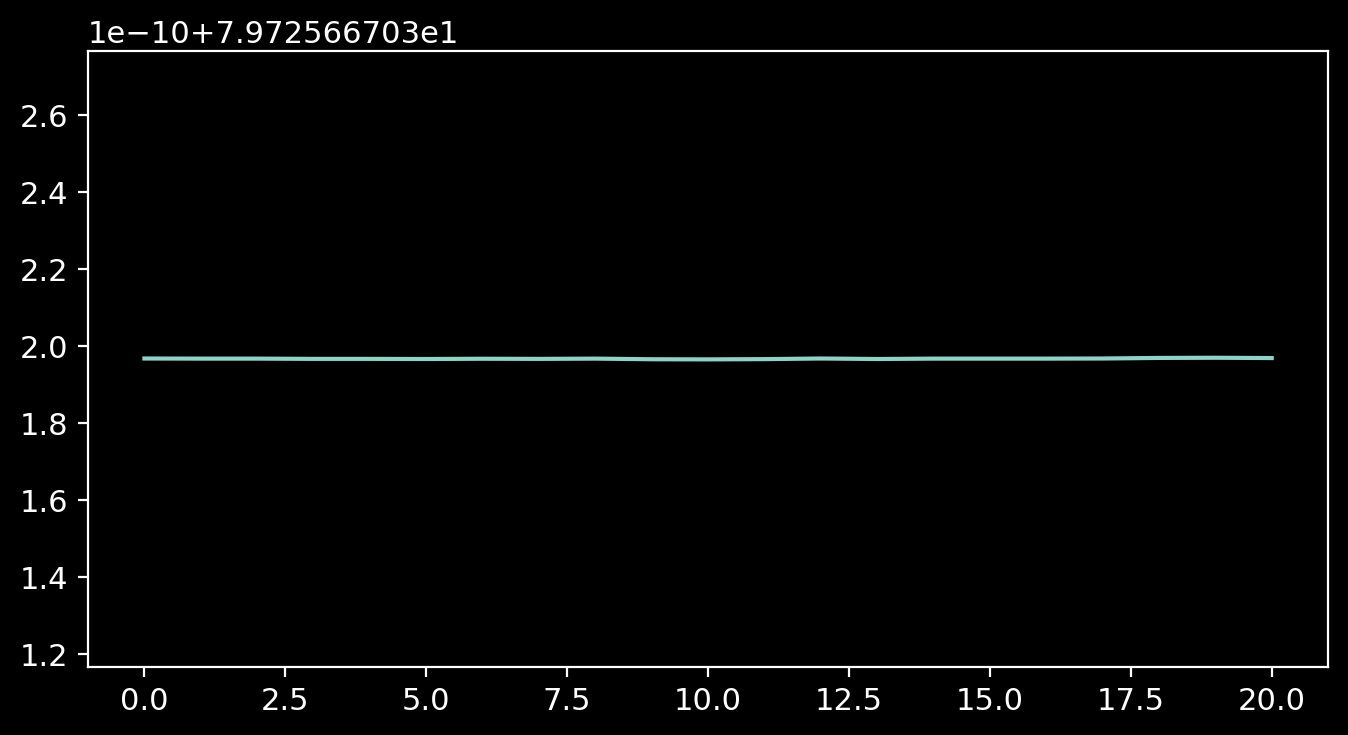

In [10]:
with h5py.File(filename, 'r') as data:
    casimir = []
    for k in range(data['state'].shape[0]):
        omega = data['state'][k]
        casimir += [np.linalg.norm(omega)**2]
    casimir = np.asarray(casimir)
    plt.figure(figsize=(8,4))
    plt.plot(casimir)

## Animate the results

In [14]:
with h5py.File(filename, 'r') as data:
    anim = qf.create_animation2(filename.replace(".hdf5",".mp4"), data['state'], projection='hammer', N=256)
anim

  0%|          | 0/21 [00:00<?, ? frames/s]

## Compute canonical decomposition

In [12]:
[Ws,Wr] = qf.analysis.scale_decomposition(W)

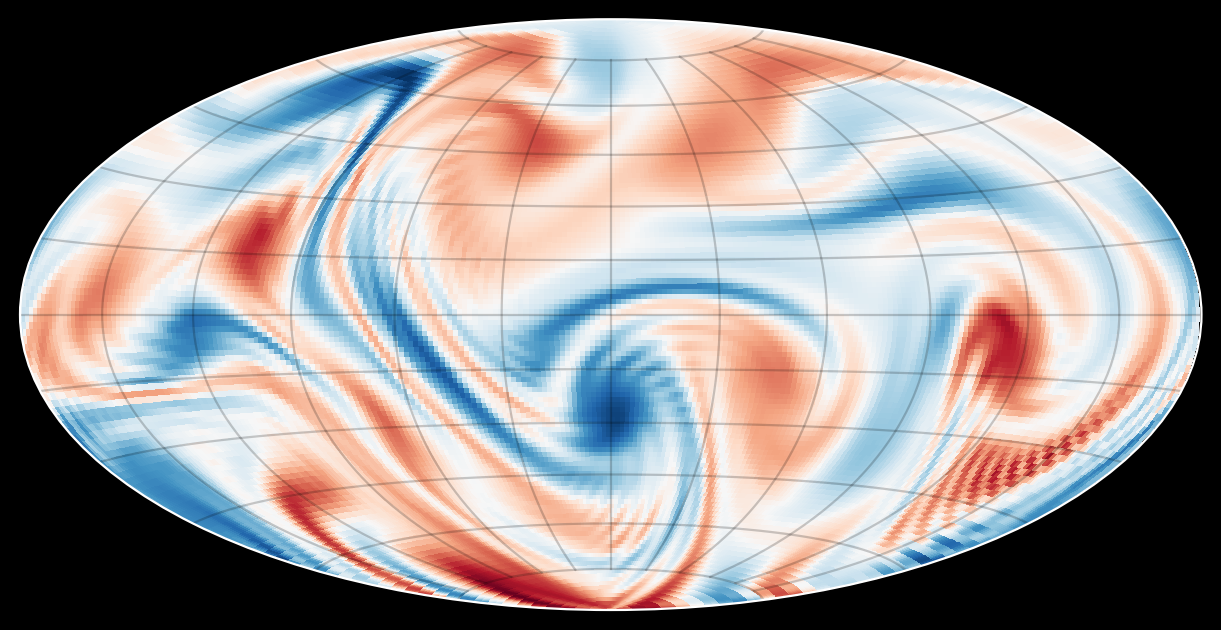

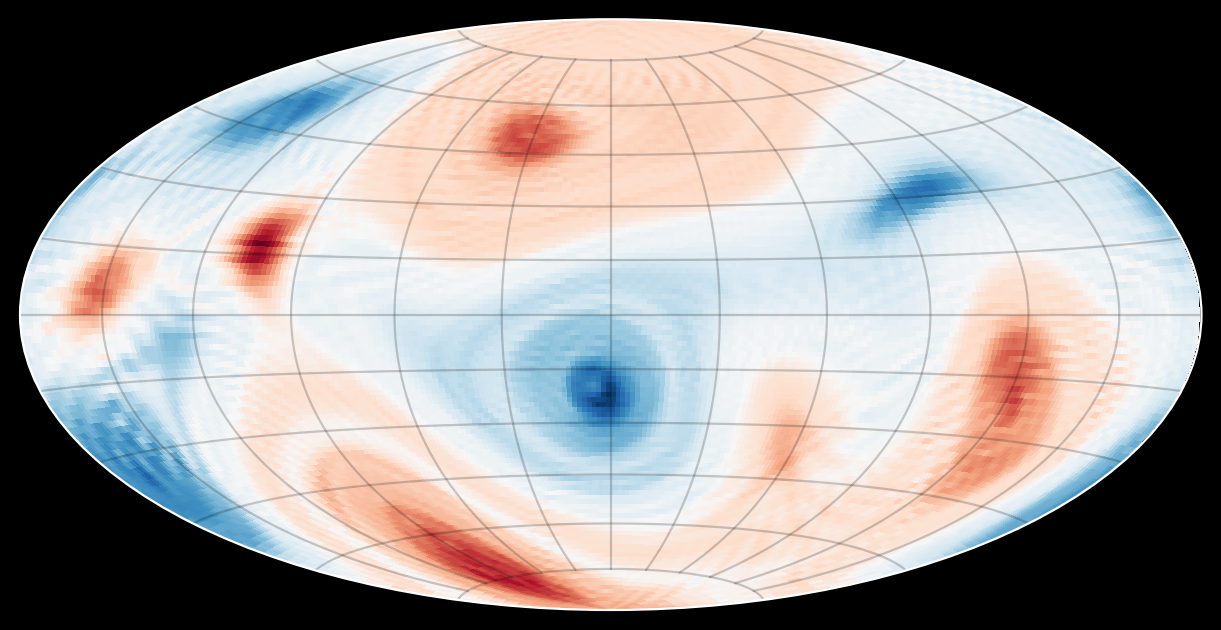

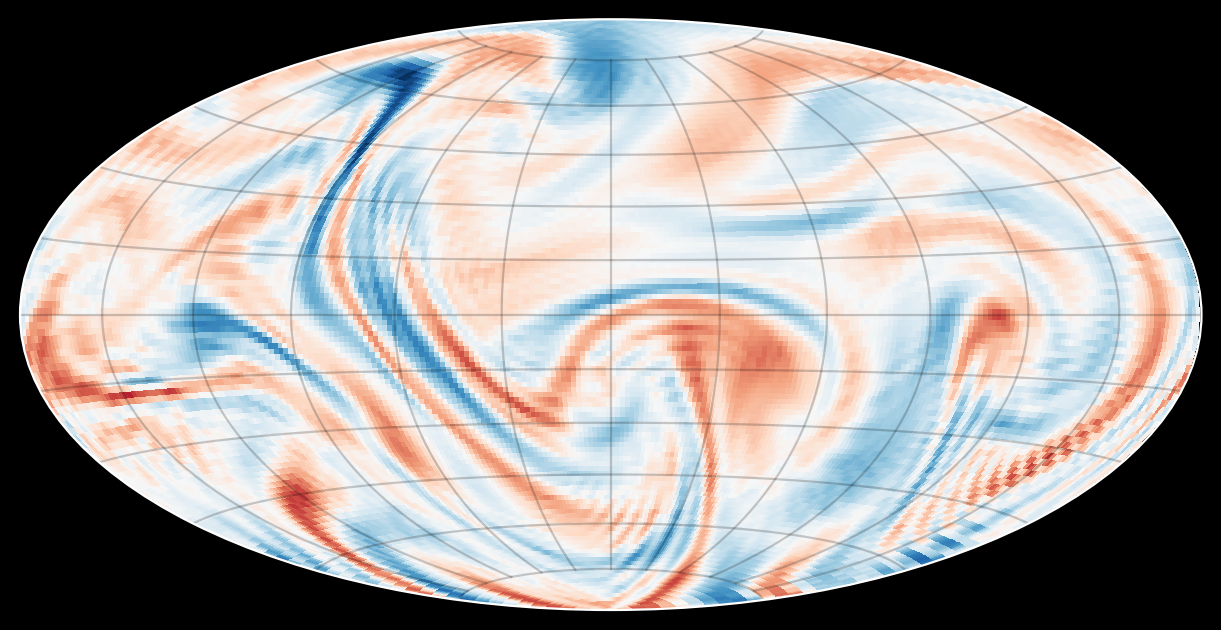

In [13]:
for Ww in [W, Ws, Wr]:
    qf.plot2(Ww, projection='hammer')

## Run on cluster

In [8]:
import quflow.cluster as cluster

In [14]:
epsilon = 0.01

def forcing(P, W):
    Ws, Wr = qf.scale_decomposition(W, P)
    return -epsilon*Wr

force_code = In[len(In)-1]

In [15]:
# Start longer simulation on cluster
cluster.solve(filename, qstepsize=qstepsize, time=time, inner_time=inner_time, 
              method_kwargs={'forcing':forcing}, prerun=force_code,
              animate=True, simulate=True,
              upload=True, submit=True)

/Users/moklas/Documents/Coding/quflow/quflow/cluster.py:438: UserWarning: Could not establish jobstatus.
  warnings.warn("Could not establish jobstatus.")


#### CREATING RUN FILES ####
########### DONE ###########

#### UPLOADING FILES TO SERVER ####
> rsync -auv my_sim_N_128.hdf5 my_sim_N_128_run.py my_sim_N_128_submit.sh my_sim_N_128_args.pickle my_sim_N_128_cluster.pickle vera2:simulations/my_sim_N_128
building file list ... done
created directory simulations/my_sim_N_128
my_sim_N_128.hdf5
my_sim_N_128_args.pickle
my_sim_N_128_cluster.pickle
my_sim_N_128_run.py
my_sim_N_128_submit.sh

sent 7302271 bytes  received 130 bytes  14604802.00 bytes/sec
total size is 7300991  speedup is 1.00
> rsync -auv --exclude __pycache__ --exclude .DS_Store /Users/moklas/Documents/Coding/quflow/quflow vera2:simulations/my_sim_N_128
building file list ... done
quflow/
quflow/__init__.py
quflow/cluster.py
quflow/dynamics.py
quflow/graphics.py
quflow/io.py
quflow/quantization.py
quflow/splittingflow.py
quflow/transforms.py
quflow/utils.py
quflow/laplacian/
quflow/laplacian/__init__.py
quflow/laplacian/direct.py
quflow/laplacian/sparse.py
quflow/laplacian/tri

In [28]:
cluster.jobstatus()

JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [27]:
# Check status
cluster.status(filename)

 Animation: 100%|##########| 79/79 [00:10<00:00,  7.24 frames/s] (jobstatus: not running)


In [29]:
cluster.retrieve(filename, onlysim=True)

> rsync -auv vera2:'simulations/my_sim_N_128/my_sim_N_128.mp4' .
receiving file list ... done
my_sim_N_128.mp4

sent 8744 bytes  received 1227898 bytes  824428.00 bytes/sec
total size is 1227463  speedup is 0.99
